# Charles Hodgins - LSTM Market Forecasting

Import Libraries


In [ ]:
import os
import datetime as dt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
plt.style.use("bmh")
%matplotlib inline


Data API

In [ ]:
stock = 'NVDA'
period = '10y'
interval = '1d'
dataframe = yf.download([stock], period=period, interval=interval)
dataframe = dataframe.xs('NVDA', level='Ticker', axis=1)
print(dataframe.columns)

In [ ]:
plt.figure()
plt.suptitle(f'{stock} over last {period} per {interval}')

plt.subplot(2,2,1)
plt.plot(dataframe['Close'])
plt.title('Closing prices')

plt.subplot(2,2,2)
plt.plot(dataframe['Volume'])
plt.title('Trading Volume')

plt.subplot(2,2,3)
plt.plot(dataframe['High'])
plt.title('High price')

plt.subplot(2,2,4)
plt.plot(dataframe['Low'])
plt.title('Low price')
    
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Clean the dataset

Average Daily Return

In [ ]:
def calculate_returns(df):
    df['Returns'] = df['Close'].pct_change()
    return df

def normalize_z_score(data):
    mean = data.mean()
    std = data.std()
    return (data-mean)/std, mean, std

def create_sequences(data, window_size):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

scaler = MinMaxScaler(feature_range=(0,1))

dataframe = calculate_returns(dataframe)

window_size = 60
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
history_selection = 1500

original_dataset = dataframe['Returns'].dropna().values.reshape(-1,1)
dataset = original_dataset[-history_selection:]
# normalized_dataset, _mean, _std = normalize_z_score(dataset)
total_len = len(dataset)
train_end = int(total_len*train_ratio)
val_end = int(total_len*(train_ratio+val_ratio))

train_data = dataset[:train_end]

train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(dataset[train_end:val_end])
test_data = scaler.transform(dataset[val_end:])

x_train, y_train = create_sequences(train_data, window_size)

x_val, y_val = create_sequences(val_data, window_size)

x_test, y_test = create_sequences(test_data, window_size)
print(test_data[0:6])
print(x_test[0], y_test[0])

print(len(x_train), len(x_val), len(x_test))

[[0.29692103]
 [0.4756797 ]
 [0.31257722]
 [0.46976036]
 [0.58100601]
 [0.42767657]]
[0.29692103 0.4756797  0.31257722] 0.46976035697362334
1197 147 147


In [986]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

class ForecasterLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size, num_layers, output_size, dropout = 0):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 25),
            nn.Linear(25, output_size)
        )

    def forward(self, x):
        # input shape - (batch_size, sequence_length, input_size)
        # lstm_out - (batch, sequence, D*H_out)
        # lstm_out, (h_n, c_n) = self.LSTM1(input) 
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.permute(0,2,1)
        # Back to (batch, seq_len, channels)
        lstm_out2, (h_n2, c_n2) = self.lstm(x)
        last_hidden_state = lstm_out2[:,-1,:] # shape(batch_size, hidden_size)
        out = self.fc(last_hidden_state)
        return out
    
def training_loop(model, optim, criterion, train_loader, val_loader, epochs,scheduler = 'na'):
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs+1):  
        model.train()
        train_loss = 0
        val_loss = 0
        for x_batch, y_batch in train_loader:
            optim.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optim.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        #validation phase
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * x_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        if scheduler != 'na':
            scheduler.step()
        
        if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    return train_losses, val_losses

x_train_tensor = torch.from_numpy(x_train).float().reshape((x_train.shape[0], x_train.shape[1], 1))
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
    
x_val_tensor = torch.from_numpy(x_val).float().reshape((x_val.shape[0], x_val.shape[1], 1))
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

x_test_tensor = torch.from_numpy(x_test).float().reshape((x_test.shape[0], x_test.shape[1], 1))
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

x_batch shape: torch.Size([32, 3, 1])
y_batch shape: torch.Size([32, 1])


In [ ]:
input_size = 1
hidden_size = 128
num_layers = 1
convolution_channels = 64
output_size = 1
dropout = 0.4
num_epochs = 200
learning_rate = 0.0001
step_size = 20
weight_decay = 1e-4
gamma = 0.4


model = ForecasterLSTM(input_size,convolution_channels,hidden_size, num_layers,output_size,dropout)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
lossfunction = torch.nn.MSELoss()
scheduler = 'na'
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)

train_losses, val_losses = training_loop(model, optimizer, lossfunction, train_loader, val_loader, num_epochs,scheduler)
hyperparameters = {
    'sequence_length':window_size,
    'history': history_selection,
    'input_size':input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'convolution_channels':convolution_channels,
    'output_size':output_size,
    'dropout':dropout,
    'num_epochs': num_epochs,
    'learning_rate':learning_rate,
    'batch_size':batch_size,
    'optimizer':{
        'name':type(optimizer).__name__,
        'weight_decay': weight_decay
        },
    'scheduler': {
        'scheduler':scheduler,
        'step_size':step_size,
        'gamma':gamma
        },
    'loss_function':lossfunction
}

with open('hyperparameters.txt', 'a') as f:
    f.write((str(val_losses[-1]))+ ': '+str(hyperparameters)+'\n')

c:\Users\C3hod\OneDrive\Documents\NNDL\market-forecasting\.market-forecasting\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/200 | Train Loss: 0.051592 | Val Loss: 0.424406
Epoch 5/200 | Train Loss: 0.018345 | Val Loss: 0.214812
Epoch 10/200 | Train Loss: 0.007387 | Val Loss: 0.056196
Epoch 15/200 | Train Loss: 0.002798 | Val Loss: 0.002483
Epoch 20/200 | Train Loss: 0.002181 | Val Loss: 0.001042
Epoch 25/200 | Train Loss: 0.001863 | Val Loss: 0.001410
Epoch 30/200 | Train Loss: 0.001658 | Val Loss: 0.001118
Epoch 35/200 | Train Loss: 0.001480 | Val Loss: 0.001011
Epoch 40/200 | Train Loss: 0.001469 | Val Loss: 0.000960
Epoch 45/200 | Train Loss: 0.001392 | Val Loss: 0.001034
Epoch 50/200 | Train Loss: 0.001432 | Val Loss: 0.000871
Epoch 55/200 | Train Loss: 0.001358 | Val Loss: 0.000849
Epoch 60/200 | Train Loss: 0.001173 | Val Loss: 0.000870
Epoch 65/200 | Train Loss: 0.001320 | Val Loss: 0.000846
Epoch 70/200 | Train Loss: 0.001325 | Val Loss: 0.000853
Epoch 75/200 | Train Loss: 0.001185 | Val Loss: 0.000855
Epoch 80/200 | Train Loss: 0.001159 | Val Loss: 0.000874
Epoch 85/200 | Train Loss: 0.0011

In [1014]:
model_path = 'benchmark_model.pth'
torch.save(model.state_dict(), model_path)   

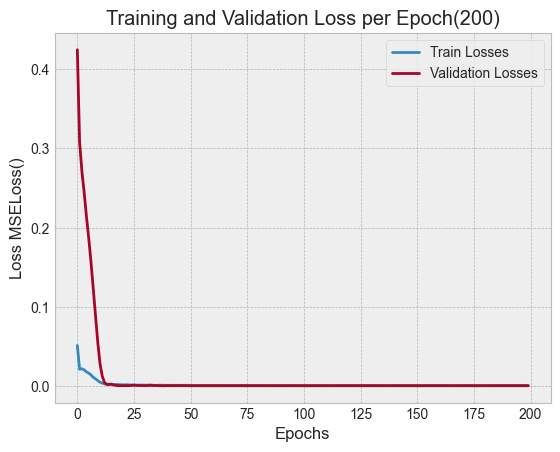

In [1015]:
plt.figure()
plt.title(f'Training and Validation Loss per Epoch({num_epochs})')
plt.ylabel(f'Loss {str(lossfunction)}')
plt.xlabel('Epochs')
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train Losses','Validation Losses'])
plt.show()

In [1016]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

predictions = []
labels = []
test_loss = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = lossfunction(outputs, y_batch)
        test_loss += loss.item() * y_batch.size(0)

        predictions.append(outputs)
        labels.append(y_batch)

test_loss /= len(test_loader.dataset)
all_preds = scaler.inverse_transform(torch.cat(predictions))
all_labels = scaler.inverse_transform(torch.cat(labels))
print("Test loss:", test_loss)
print("Sample outputs:", all_preds[-5:])
print("Sample labels:", all_labels[-5:])

Test loss: 0.0005970615768871669
Sample outputs: [[185.19871135]
 [188.28692215]
 [190.42078545]
 [190.72621265]
 [189.78233657]]
Sample labels: [[187.24000033]
 [188.89000531]
 [187.62000068]
 [185.53998722]
 [185.0399937 ]]


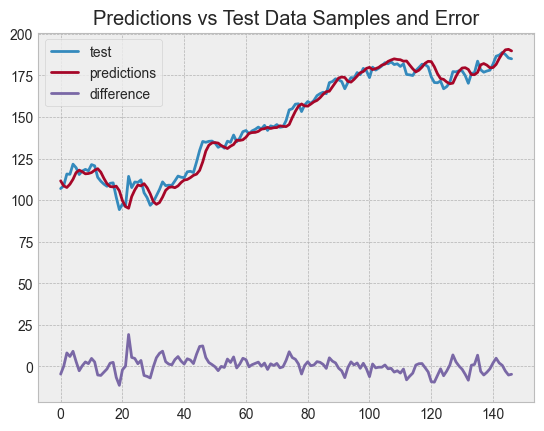

In [1017]:
plt.figure()
plt.title(f'Predictions vs Test Data Samples and Error')
plt.plot(all_labels)
plt.plot(all_preds)
plt.plot(all_labels-all_preds)
plt.legend(['test','predictions', 'difference'])
plt.show()
# plt.plot(valid[['Close', 'Predictions']])
